<a href="https://colab.research.google.com/github/jirikadlec2/cloud_computing_workshop/blob/main/notebooks/lake_chad_wofs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the required packages if they are not already present
! pip install pystac_client odc-stac matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 623.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.4 MB/s eta 0:00:00


In [15]:
# Importing the dependencies

from pystac_client import Client
from odc.stac import configure_rio, stac_load

import matplotlib.pyplot as plt
import pandas as pd

Configure the bands

In [ ]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16"
            }
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [16]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [17]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [34]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
#bbox = [13.5, 13.7, 13.7, 13.9]
bbox = [13.1, 12.5, 15.1, 14.5]

# Set a start and end date
start_date = "2020-01-01"
end_date = "2025-07-01"

# Set the STAC collections
collections = ["gm_s2_rolling"]

In [35]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 780 datasets


In [36]:
crs = "EPSG:6933"
resolution = 500

ds = stac_load(
    items,
    bands=("B03","B11",),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 100MB
Dimensions:      (y: 498, x: 387, time: 65)
Coordinates:
  * y            (y) float64 4kB 1.831e+06 1.83e+06 ... 1.583e+06 1.582e+06
  * x            (x) float64 3kB 1.264e+06 1.264e+06 ... 1.456e+06 1.457e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 520B 2020-01-01 2020-02-01 ... 2025-05-01
Data variables:
    B03          (time, y, x) float32 50MB dask.array<chunksize=(1, 498, 387), meta=np.ndarray>
    B11          (time, y, x) float32 50MB dask.array<chunksize=(1, 498, 387), meta=np.ndarray>

In [37]:
ds["MNDWI"] = (ds.B03 - ds.B11) / (ds.B03 + ds.B11)
mndwi = ds.MNDWI.compute()


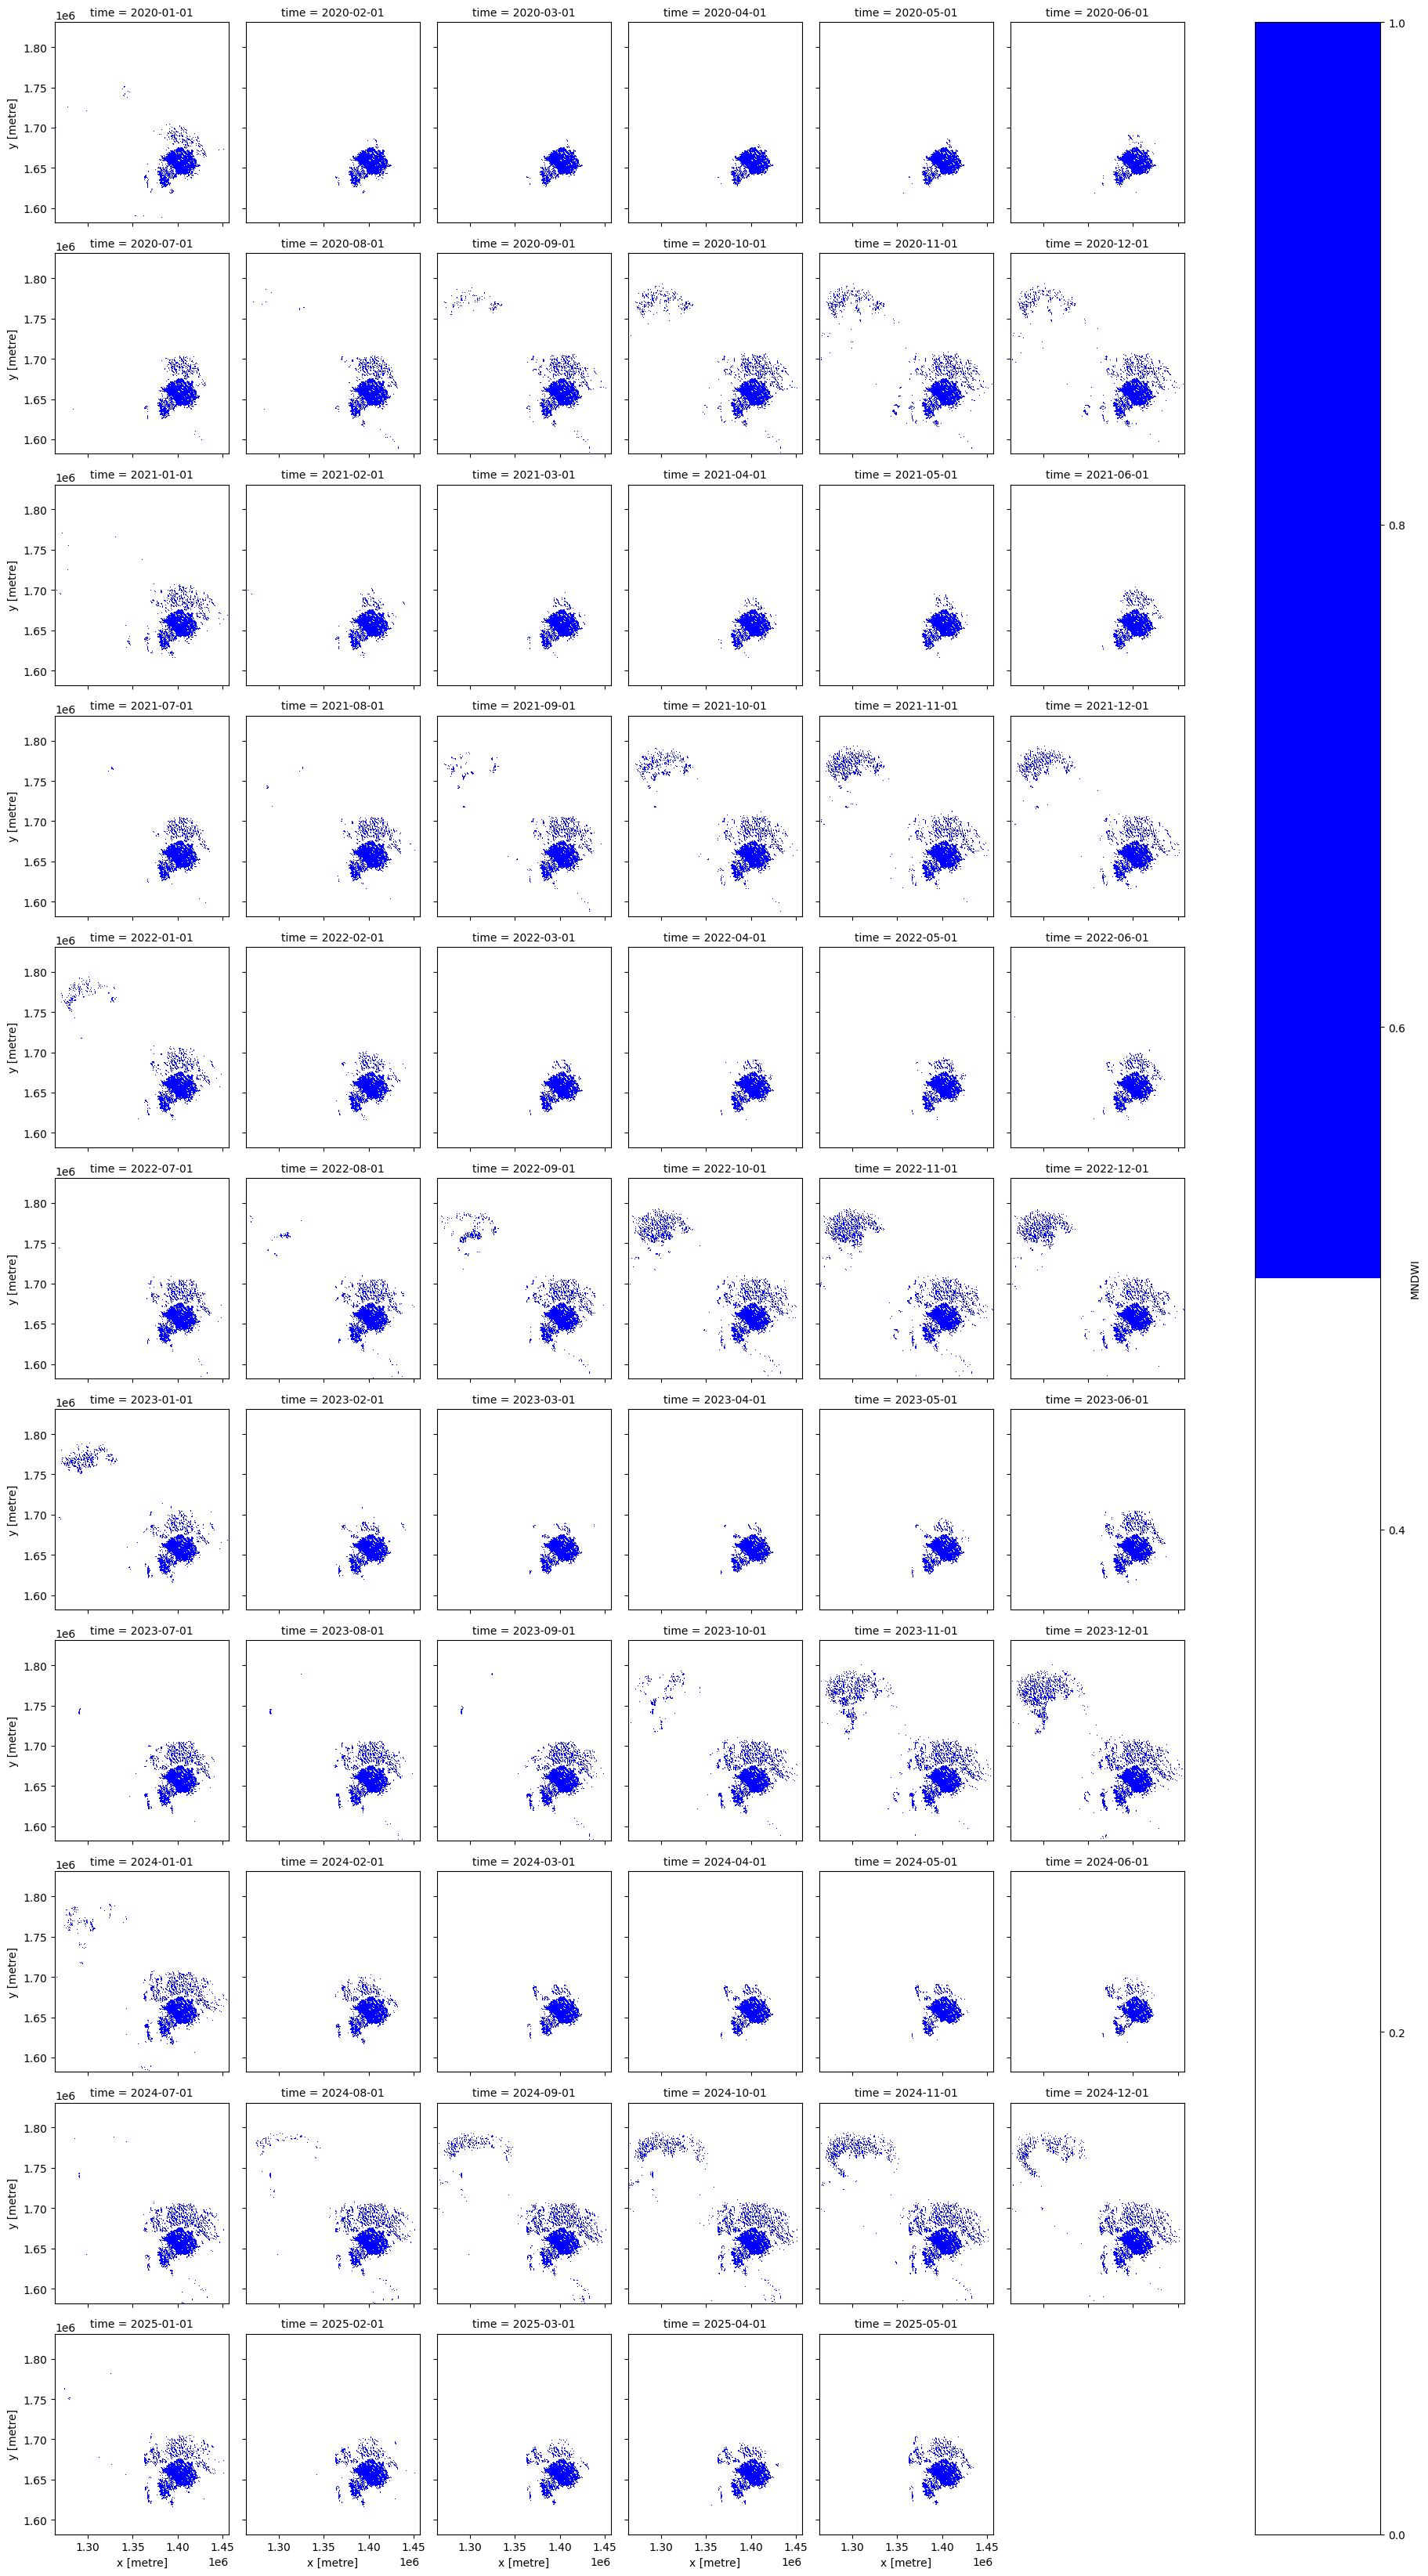

In [46]:
# Create a boolean mask for pixels where MNDWI is greater than the threshold (i.e., water)
from matplotlib.colors import ListedColormap
cmap_custom = ListedColormap(['white', 'blue'])

mndwi_threshold = 0.4
water_mask = mndwi > mndwi_threshold

water_mask.compute().plot(col="time", col_wrap=6, cmap=cmap_custom)

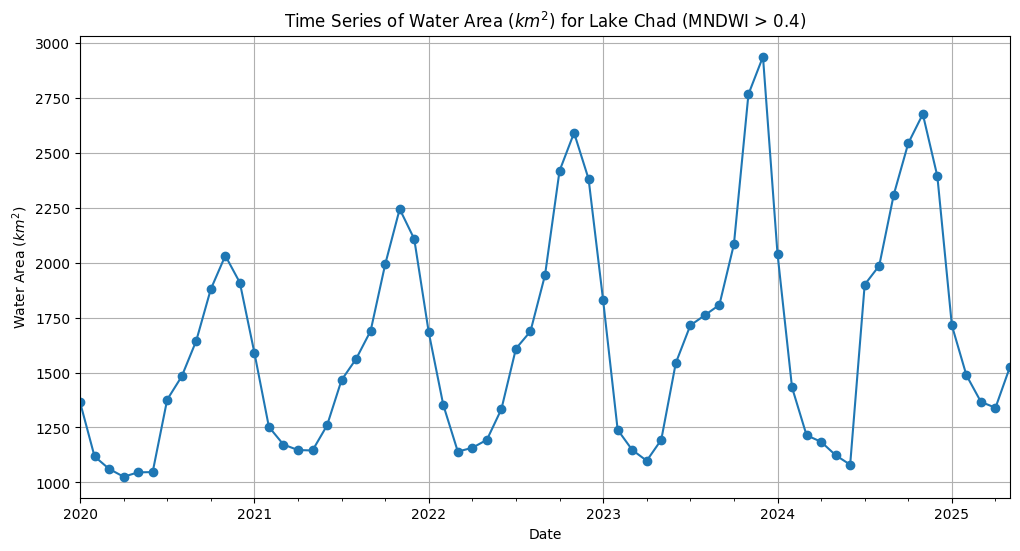

The water area time series data has been saved to water_area_time_series.csv


In [45]:
# Define the MNDWI threshold to identify water
mndwi_threshold = 0.4

# Calculate the area of a single pixel in square kilometers
pixel_area_sq_m = resolution * resolution
pixel_area_sq_km = pixel_area_sq_m / 1000000.0

# Create a boolean mask for pixels where MNDWI is greater than the threshold (i.e., water)
water_mask = mndwi > mndwi_threshold

# Count the number of water pixels for each time step
water_pixel_count = water_mask.sum(dim=["x", "y"])

# Calculate the total water area in square kilometers for each time step
water_area_sq_km = water_pixel_count * pixel_area_sq_km

# Convert the xarray DataArray to a pandas Series for plotting
water_area_series = water_area_sq_km.compute().to_pandas()

# Plot the time series of water area
plt.figure(figsize=(12, 6))
water_area_series.plot(style='-o')
plt.title(f"Time Series of Water Area ($km^2$) for Lake Chad (MNDWI > {mndwi_threshold})")
plt.xlabel("Date")
plt.ylabel("Water Area ($km^2$)")
plt.grid(True)
plt.show()

# Save the time series data to a CSV file
water_area_series.to_csv("water_area_time_series.csv")

print("The water area time series data has been saved to water_area_time_series.csv")